In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

import wandb

In [2]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

wandb.login()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
numclasses = 21
lr = 0.001
batch_size = 3
crop_size=(320,480)
num_epochs = 15

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Network error (SSLError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
# convert the mass to label
cm2lbl=np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]]=i

def image2label(im):
    data=np.array(im,dtype='int32')
    idx=(data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return np.array(cm2lbl[idx],dtype='int64')

In [4]:
def rand_crop(image,label,height,width):
    h,w,_=image.shape
    h_pad = max(0, height - h)
    w_pad = max(0, width - w)
    image = np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant')
    label = np.pad(label, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant')
    h,w,_=image.shape
    top=random.randint(0,h-height)
    left=random.randint(0,w-width)
    image=image[top:top+height,left:left+width]
    label=label[top:top+height,left:left+width]
    return image,label

def img_transforms(im,label,crop_size):
    im,label=rand_crop(im,label,*crop_size)
    im_tfs=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.Resize(crop_size)
    ])
    im=im_tfs(im)
    label=image2label(label)
    label=torch.from_numpy(label)
    return im,label

In [5]:
class VOCSegmentation(Dataset):
    def __init__(self, image_dir, label_dir, transform,crop_size=crop_size):
        self.image_names = []
        self.mask_names = []
        self.crop_size = crop_size
        self.transform = transform
        for image_file in os.listdir(image_dir):
            self.image_names.append(os.path.join(image_dir, image_file))
        for label_file in os.listdir(label_dir):
            self.mask_names.append(os.path.join(label_dir, label_file))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image  = self.image_names[index]
        mask = self.mask_names[index]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        image, mask = self.transform(image,mask,self.crop_size)
        return image, mask



In [6]:
VOCData = VOCSegmentation('VOC Segmentation Dataset/images', 'VOC Segmentation Dataset/masks',img_transforms)
train_size = int(0.7* len(VOCData))
val_size = int(0.2* len(VOCData))
test_size = len(VOCData) - train_size - val_size
train_dataset, val_dataset,test_dataset = random_split(VOCData, [train_size,val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

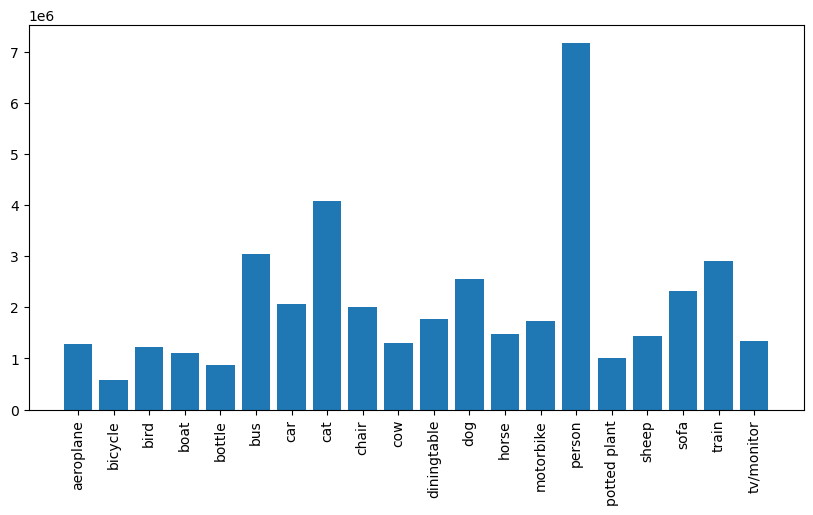

In [7]:
classCount = np.zeros(numclasses)
for data in train_loader:
    label = data[1]
    for curLabel in label:
        for i in range(numclasses):
            classCount[i] += torch.sum(curLabel == i)

# visualize the class distribution removing the 0th class
classCount = classCount[1:]
plt.figure(figsize=(10,5))
plt.bar(classes[1:],classCount)
plt.xticks(rotation=90)
plt.show()



In [7]:
from torchvision import models
model = models.segmentation.fcn_resnet50(pretrained=True,weights='DEFAULT')
# wandb.init(project="q2")

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# wandb.watch(model, criterion, log="all", log_freq=10)

In [17]:
for i in range (num_epochs):
    train_loss = 0
    train_acc = 0

    model = model.to(device)
    model.train()
    for data in iter(train_loader):
        im = Variable(data[0].to(device))
        label = Variable(data[1].to(device))
        out = model(im)['out']
        out = F.log_softmax(out, dim=1)
        loss = criterion(out,label)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"loss": loss})
    print('Epoch: {}, Loss: {:.5f}'.format(i, train_loss/len(train_loader)))

Epoch: 1, Loss: 0.61427
Epoch: 2, Loss: 0.57183
Epoch: 3, Loss: 0.32611
Epoch: 4, Loss: 0.33611
Epoch: 5, Loss: 0.30142
Epoch: 6, Loss: 0.25746
Epoch: 7, Loss: 0.21384
Epoch: 8, Loss: 0.15037
Epoch: 9, Loss: 0.12627
Epoch: 10, Loss: 0.12953


In [10]:
PATH = 'Q2_FCNResnet50.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Q2 class-wise accuracies and other performance metrics 

In [11]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def get_evaluators(confusionMatrix):
    precision = np.diag(confusionMatrix) / (confusionMatrix.sum(axis=0))
    recall = np.diag(confusionMatrix) / (confusionMatrix.sum(axis=1))
    f1_score = 2 * precision * recall / (precision + recall+1e-12)
    
    return precision, recall, f1_score


def get_iou_score(y_true, y_pred, num_classes):
    iou_list = []
    for c in range(num_classes):
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        iou = TP / (TP + FP + FN + 1e-16)
        iou_list.append(iou)
    return iou_list

def evaluators(y_true, y_pred, num_classes):
    iou_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []
    for c in range(num_classes):
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        TN = np.sum((y_true != c) & (y_pred != c))
        precision = TP / (TP + FP+0.0000000000000001)
        recall = TP / (TP + FN +0.0000000000000001)
        f1 = 2 * precision * recall / (precision + recall+0.0000000000000001)
        accuracy = (TP + TN) / (TP + TN + FP + FN +0.0000000000000001)
        iou = TP / (TP + FP + FN + 0.0000000000000001)
        # if a class is not present in the image, then the iou, precision, recall and f1 score will be 0
        # so we will count and add the sum only if the IoU is greater than the given thereshold
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        iou_list.append(iou)
    
    f1_list = np.array(f1_list)
    precision_list = np.array(precision_list)
    recall_list = np.array(recall_list)
    accuracy_list = np.array(accuracy_list)
    iou_list = np.array(iou_list)
    return f1_list, precision_list, recall_list, accuracy_list, iou_list

def getMaxIndexWise(arr1, arr2):
    ans = []
    for i in range(len(arr1)):
        ans.append(max(arr1[i], arr2[i]))
    return np.array(ans)

In [12]:
model = model.to(device)
model.eval()
with torch.no_grad():
    finalPrecision = 0
    finalRecall = 0
    finalF1Score = 0
    finalIouScore = 0
    finalAccuracyScore = 0
    totalDivider = np.zeros(21)
    for data in iter(test_loader):
        image = Variable(data[0].to(device))
        trueLabel = Variable(data[1].to(device))
        predictedLabel = model(image)['out']
        predictedLabel = F.log_softmax(predictedLabel,dim=1)
        predictedLabel = predictedLabel.max(dim=1)[1].data.cpu().numpy()
        trueLabel = trueLabel.data.cpu().numpy()
        precision = np.zeros(21)
        recall = np.zeros(21)
        f1_score =  np.zeros(21)
        iouScore = np.zeros(21)
        accuracy = np.zeros(21)
        for curTrueLabel, curPredictedLabel in zip(trueLabel, predictedLabel):
            temp_f1_score,temp_precision, temp_recall,temp_accuracy,tempIOU = evaluators(curTrueLabel, curPredictedLabel, 21)

            # since if a class is not present in the image, then the TP will be 0 so the iou,precision,recall will be 0
            # so we will count classwise and add the sum only if the IoU is greater than the given thereshold

            for i in range(21):
                if(tempIOU[i] >= 0.5):
                    totalDivider[i] += 1
                    precision[i] += temp_precision[i]
                    recall[i] += temp_recall[i]
                    f1_score[i] += temp_f1_score[i]
                    iouScore[i] += tempIOU[i]
                    accuracy[i] += temp_accuracy[i]
    
            
        finalPrecision += precision
        finalRecall += recall
        finalF1Score += f1_score
        finalIouScore += iouScore
        finalAccuracyScore += accuracy

    for i in range(21):
        finalPrecision[i] /= totalDivider[i]
        finalRecall[i] /= totalDivider[i]
        finalF1Score[i] /= totalDivider[i]
        finalIouScore[i] /= totalDivider[i]
        finalAccuracyScore[i] /= totalDivider[i]

    print("final average precision classwise : ", finalPrecision)
    print("final average recall classwise : ", finalRecall)
    print("final average f1_score classwise : ", finalF1Score)
    print("final average IoU score classwise : ", finalIouScore)
    print("final average accuracy score classwise : ", finalAccuracyScore)

    print("final average precision: ", np.mean(finalPrecision))
    print("final average recall: ", np.mean(finalRecall))
    print("final average f1_score: ", np.mean(finalF1Score))
    print("final average IoU score: ", np.mean(finalIouScore))
    print("final average accuracy score: ", np.mean(finalAccuracyScore))

final average precision classwise :  [0.9551729  0.91646428 0.63405845 0.91304609 0.88934338 0.90721175
 0.95091976 0.95527142 0.91654968 0.89504423 0.92225801 0.88264
 0.95112773 0.91604495 0.84929193 0.89038011 0.78545575 0.94861682
 0.94402534 0.97041564 0.87922387]
final average recall classwise :  [0.95805126 0.92597163 0.71087282 0.92488504 0.92357458 0.9105901
 0.98456674 0.82069326 0.92507577 0.75683897 0.80996466 0.82377812
 0.88623608 0.88449786 0.88286797 0.89531776 0.76788588 0.95024654
 0.80761657 0.95254855 0.91034513]
final average f1_score classwise :  [0.95500955 0.91934248 0.67027205 0.9165395  0.89925066 0.90818463
 0.9673298  0.87548145 0.91762908 0.81121357 0.8580777  0.84061434
 0.91289178 0.89629573 0.85901062 0.88840237 0.7620607  0.94935961
 0.85605736 0.96103294 0.89195412]
final average IoU score classwise :  [0.91775263 0.85181062 0.50406705 0.84800928 0.82463837 0.84424228
 0.93693023 0.78699711 0.8589285  0.68824293 0.76123958 0.73613535
 0.84576    0.8158

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classwise iou score :  [0.4044036765665492, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49457658965708673, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


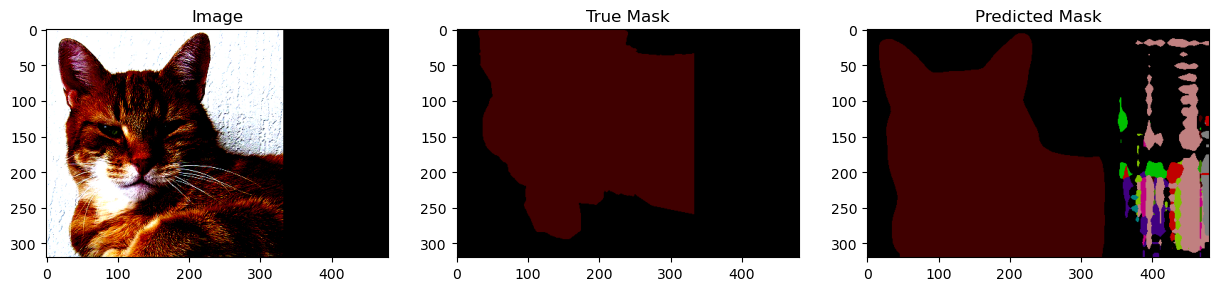

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classwise iou score :  [0.9976822916666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


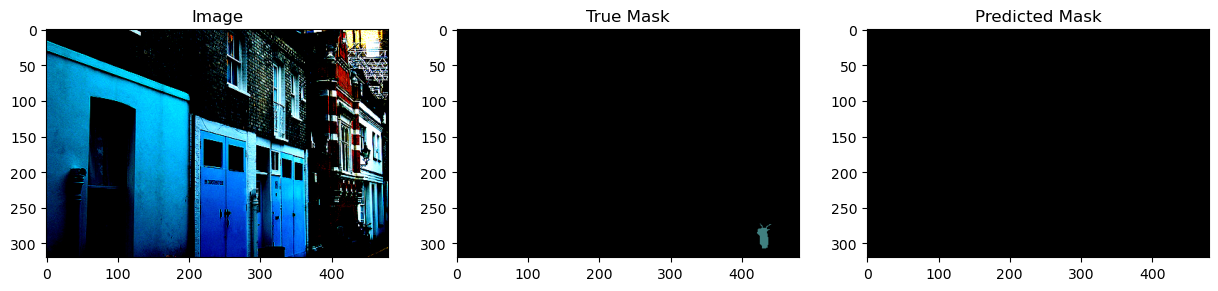

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classwise iou score :  [0.8676344056176969, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40057442135495863, 0.0, 0.0, 0.0, 0.0]


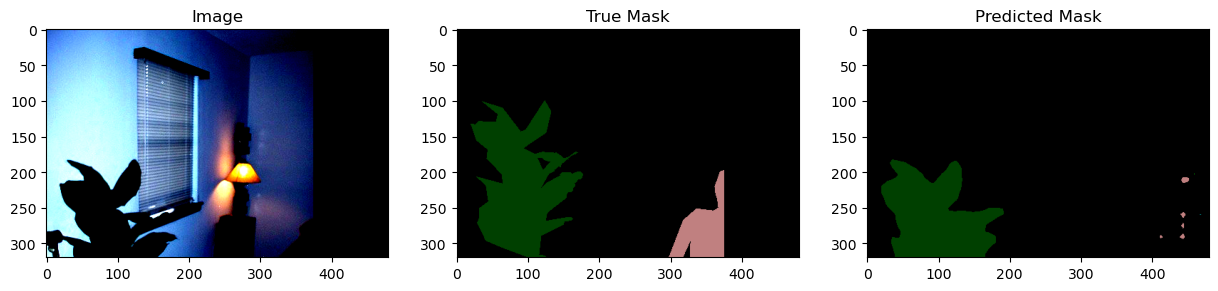

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classwise iou score :  [0.8857911812417048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015289838937133527, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


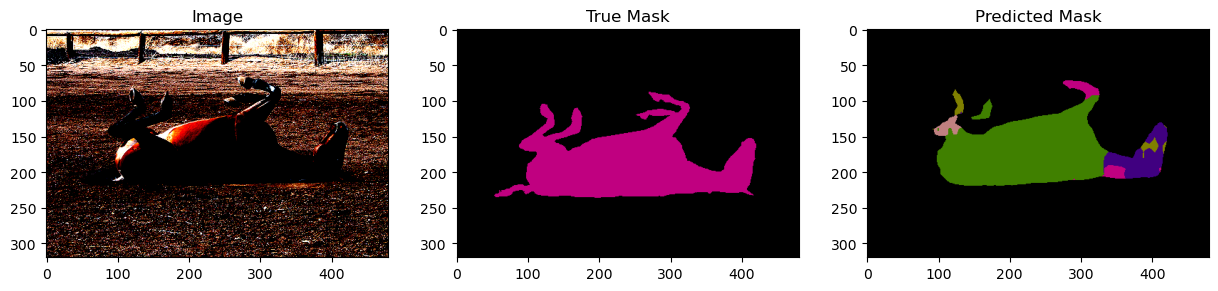

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classwise iou score :  [0.6274293090947674, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4901075763259478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


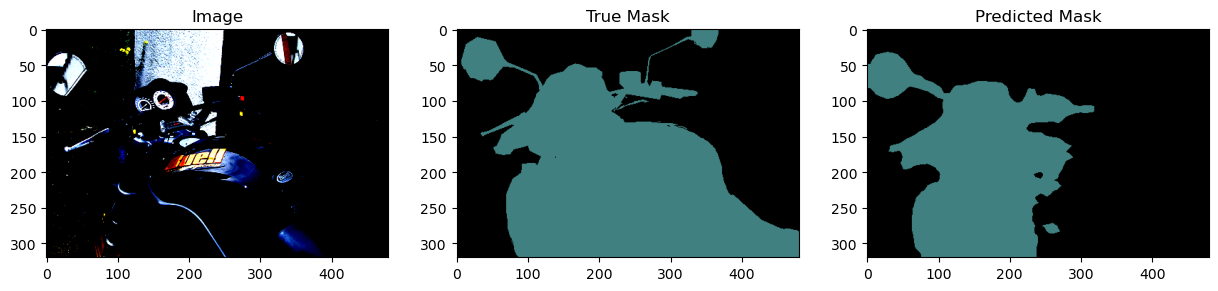

In [84]:
def convertMaskToRGB(mask):
    r= mask.shape[0]
    c= mask.shape[1]
    rgbMask = np.zeros((r,c,3), dtype=np.uint8)
    for i in range(r):
        for j in range(c):
            rgbMask[i][j] = colormap[mask[i][j]]
    return rgbMask


counter =0 
for i in range(len(test_dataset)):
    img = test_dataset[i][0]
    imageMask = test_dataset[i][1]
    predictedMask = model(img.unsqueeze(0).to(device))['out']
    predictedMask = F.log_softmax(predictedMask,dim=1)
    predictedMask = predictedMask.max(dim=1)[1].data.cpu().numpy()
    imageMask = imageMask.data.cpu().numpy()
    iou = get_iou_score(imageMask, predictedMask[0], 21)
    hasIoUGreater = False
    for i in range(1,21):
        if(iou[i] >= 0.5):
            hasIoUGreater = True
            break
    if(not hasIoUGreater):
        print("classwise iou score : ", iou)
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        # add title to subplot
        plt.title("Image")
        plt.imshow(img.permute(1,2,0))
        plt.subplot(1,3,2)
        plt.title("True Mask")
        plt.imshow(convertMaskToRGB(imageMask))
        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(convertMaskToRGB(predictedMask[0]))
        plt.show()
        counter += 1

    if(counter == 5):
        break
